In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [18]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [19]:
df = pd.read_csv("./sample-clothes.csv")
df = df.reset_index(names='id')

lower_col = []
for col in df.columns:
    lower_col.append(col.lower())
    
df.columns = lower_col
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            100 non-null    int64  
 1   title         100 non-null    object 
 2   review        100 non-null    object 
 3   cons_rating   100 non-null    float64
 4   cloth_class   100 non-null    object 
 5   materials     100 non-null    float64
 6   construction  100 non-null    float64
 7   color         100 non-null    float64
 8   finishing     100 non-null    float64
 9   durability    100 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 7.9+ KB
None


,id,title,review,cons_rating,cloth_class,materials,construction,color,finishing,durability
0,0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5.0,Dresses,0.0,1.0,0.0,1.0,0.0
1,1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3.0,Sweaters,0.0,0.0,1.0,0.0,1.0
2,2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1.0,Sleep,0.0,0.0,1.0,0.0,1.0
3,3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3.0,Sweaters,1.0,1.0,1.0,0.0,0.0
4,4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5.0,Dresses,1.0,0.0,0.0,0.0,0.0


# Normalization

In [20]:
# df_prc = df[['reviewer_id', 'review']].copy()

# # Remove non-ASCII
# df_prc['token_sentence'] = df_prc['review'].apply(norm.remove_non_ascii)

# # Expand contractions
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.expand_contractions)

# # Remove characters
# df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.remove_characters, args=(True,))

# # Remove enter tab
# df_prc['token_clean'] = df_prc['token_sentence'].apply(norm.remove_enter_tab)

# # Lemmatization
# df_prc['token_clean'] = df_prc['token_clean'].apply(norm.lemmatize_text)

In [21]:
# Tokenization into sentence

df_st = df.copy()
df_st['review'] = df_st['title'] + ". " + df_st['review']

df_st = df_st[['id', 'review']]

# Remove non-ASCII
df_st['token_sentence'] = df_st['review'].apply(norm.remove_non_ascii)

# Sentence Tokenization
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect (Rules Based)

In [22]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 593/593 [00:51<00:00, 11.57it/s]


In [23]:
df_st.head()

,id,review,token_sentence,token_clean,sub_aspect
0,0,So flattering and so comfortable!. I am in lov...,So flattering and so comfortable!.,so flattering and so comfortable ! .,{}
0,0,So flattering and so comfortable!. I am in lov...,I am in love with this dress!,i be in love with this dress !,{}
0,0,So flattering and so comfortable!. I am in lov...,It has a relaxed fit style as described,it have a relaxed fit style as described,{fit style}
0,0,So flattering and so comfortable!. I am in lov...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{compliment, grocery}"
0,0,So flattering and so comfortable!. I am in lov...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,"{left side, pocket}"


In [24]:
# Create summary
mask = df_st['sub_aspect'].apply(lambda x: False if len(x) == 0 else True).values

df_summary = df_st[mask].groupby(['id'])['token_sentence']\
                .apply(lambda x: '. '.join(x))\
                .reset_index()\
                .rename(columns={'token_sentence': 'summary'})

df_prc = df_st.groupby(['id'])\
                .agg({'sub_aspect': lambda x: set().union(*x),
                      'token_clean': lambda x: '. '.join(x),
                     })\
                .reset_index()

df_prc = df_prc.merge(df_summary, on='id', how='left').fillna("")
print(df_prc.info())
df_prc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           100 non-null    int64 
 1   sub_aspect   100 non-null    object
 2   token_clean  100 non-null    object
 3   summary      100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,id,sub_aspect,token_clean,summary
0,0,"{profile, pocket, fit style, left side, fabric...",so flattering and so comfortable ! .. i be in ...,It has a relaxed fit style as described. and I...
1,1,"{hand wash, first washing, wash cycle, slouchy...",cute. it pill .. great color and pattern. with...,Great color and pattern. with the on trend slo...
2,2,"{product info, bad thing, string, set, tie, wa...",it fell apart after one wash. one set fell apa...,It fell apart after one wash. One set fell apa...
3,3,"{fit, purchase, look, nice color, good care, t...",comfortable. nice color. but lot of pilling .....,nice color. I like the fit. weight. I would ha...
4,4,"{necessary spot, woman skinny, dress that.even...",cute dress that.even a short. skinny old woman...,Cute dress that.even a short. skinny old woman...


In [25]:
# # Get aspect from rules
# tqdm.pandas()
# df_prc['sub_aspect'] = df_prc['token_clean']\
#                         .progress_apply(util.get_aspect_rules)

In [26]:
# print(df_prc.info())
# df_prc.head()

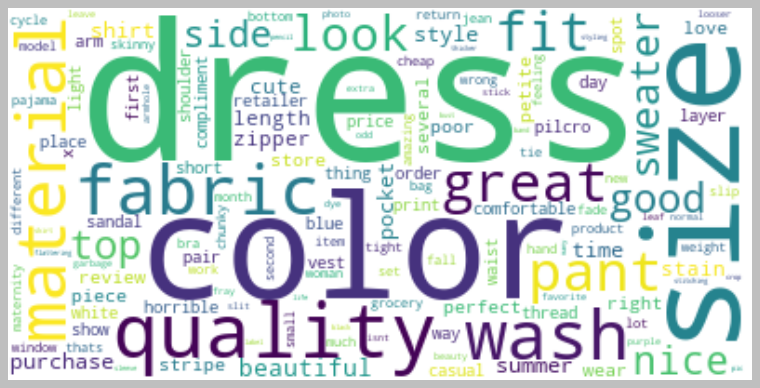

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['sub_aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
# df['sub_aspect'] = df_prc['sub_aspect'].apply(lambda x: ", ".join(list(x)))

# Get Topic

In [29]:
def get_optimum_lda(dictionary, corpus, texts, limit,
                    start=2, step=1, get_result=False,
                    iterations=20, passes=1):
    coherence_values = []
    
    for n in range(start, limit, step):
        lda = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=n,
                                         id2word=dictionary,
                                         iterations=iterations,
                                         passes=passes)
        
        # Create coherence
        coherence_model = CoherenceModel(model=lda, 
                                         texts=texts,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    
    opt_num_topics = start + coherence_values.index(max(coherence_values))
    
    lda_opt = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=opt_num_topics,
                                         id2word=dictionary)
    
    if get_result:
        print(coherence_values)
    
    return lda_opt



In [30]:
import gensim
from gensim.models import CoherenceModel


texts = df_prc['token_clean'].apply(norm.preprocess_lda)

dictionary = gensim.corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

lda_opt = get_optimum_lda(dictionary, bow_corpus,
                          texts, 10, get_result=True,
                          passes=50, iterations=100)

[0.3377940961425735, 0.33779409614257344, 0.33779409614257355, 0.33779409614257355, 0.33779409614257355, 0.33779409614257355, 0.3377940961425735, 0.3377940961425735]


In [31]:
# Print topic
for idx, topic in lda_opt.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.327*"size" + 0.247*"great" + 0.146*"comfortable" + 0.113*"order" + 0.054*"dress" + 0.051*"color" + 0.049*"cute" + 0.013*"fabric"
Topic: 1 
Words: 0.287*"dress" + 0.205*"cute" + 0.173*"fabric" + 0.137*"great" + 0.063*"comfortable" + 0.062*"order" + 0.046*"size" + 0.027*"color"
Topic: 2 
Words: 0.294*"dress" + 0.292*"color" + 0.114*"order" + 0.112*"fabric" + 0.065*"cute" + 0.053*"comfortable" + 0.042*"size" + 0.028*"great"
Topic: 3 
Words: 0.467*"size" + 0.213*"dress" + 0.116*"comfortable" + 0.081*"order" + 0.045*"cute" + 0.044*"fabric" + 0.028*"color" + 0.007*"great"


In [32]:
def predict_topic(text):
    text = util.preprocess_lda(text)
    bow_vector = dictionary.doc2bow(text)
    
    result = sorted(lda_opt[bow_vector], 
                    key=lambda x: -1*x[1])[0][0]
    
    return result
    
# Extract keywords into a dictionary or list
threshold = 0.1
topics_dict = {}
for topic_num, topic in lda_opt.show_topics(num_topics=10,
                                                num_words=10,
                                                formatted=False):
    keywords = [word for word, w in topic if w > threshold]
    topics_dict[topic_num] = keywords

In [33]:
topics_dict

{0: ['size', 'great', 'comfortable', 'order'],
 1: ['dress', 'cute', 'fabric', 'great'],
 2: ['dress', 'color', 'order', 'fabric'],
 3: ['size', 'dress', 'comfortable']}

In [34]:
df = df.merge(df_prc[['id', 'summary', 'sub_aspect']], on='id', how='left', )

In [35]:
tqdm.pandas()
df['topic'] = df_prc['token_clean'].progress_apply(predict_topic)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 160.72it/s]


In [36]:
tqdm.pandas()
df['key_topic'] = df['topic']\
                    .progress_apply(lambda x: ", ".join(topics_dict[x]))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [37]:
tqdm.pandas()
df['sub_aspect'] = df['sub_aspect']\
                    .progress_apply(lambda x: ", ".join(list(x)))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 20212.54it/s]


In [38]:
df.head()

,id,title,review,cons_rating,cloth_class,materials,construction,color,finishing,durability,summary,sub_aspect,topic,key_topic
0,0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5.0,Dresses,0.0,1.0,0.0,1.0,0.0,It has a relaxed fit style as described. and I...,"profile, pocket, fit style, left side, fabric,...",3,"size, dress, comfortable"
1,1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3.0,Sweaters,0.0,0.0,1.0,0.0,1.0,Great color and pattern. with the on trend slo...,"hand wash, first washing, wash cycle, slouchy ...",1,"dress, cute, fabric, great"
2,2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1.0,Sleep,0.0,0.0,1.0,0.0,1.0,It fell apart after one wash. One set fell apa...,"product info, bad thing, string, set, tie, was...",0,"size, great, comfortable, order"
3,3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3.0,Sweaters,1.0,1.0,1.0,0.0,0.0,nice color. I like the fit. weight. I would ha...,"fit, purchase, look, nice color, good care, th...",2,"dress, color, order, fabric"
4,4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5.0,Dresses,1.0,0.0,0.0,0.0,0.0,Cute dress that.even a short. skinny old woman...,"necessary spot, woman skinny, dress that.even,...",1,"dress, cute, fabric, great"


In [39]:
df.to_csv('result_clothes.csv', index=False)